## Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Benchmarking metrics

| **Metric**                                         | **Description**                                                                                                            |
|----------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------|
| sanity.data\_mismatch.score                        | Data types mismatch between the real//synthetic features                                                                   |
| sanity.common\_rows\_proportion.score              | Real data copy-paste in the synthetic data                                                                                 |
| sanity.nearest\_syn\_neighbor\_distance.mean       | Computes the \textless{}reduction\textgreater{}(distance) from the real data to the closest neighbor in the synthetic data |
| sanity.close\_values\_probability.score            | the probability of close values between the real and synthetic data.                                                       |
| sanity.distant\_values\_probability.score          | the probability of distant values between the real and synthetic data.                                                     |
| stats.jensenshannon\_dist.marginal                 | the average Jensen-Shannon distance                                                                                        |
| stats.chi\_squared\_test.marginal                  | the one-way chi-square test.                                                                                               |
| stats.feature\_corr.joint                          | the correlation/strength-of-association of features in data-set with both categorical and continuous features              |
| stats.inv\_kl\_divergence.marginal                 | the average inverse of the Kullback–Leibler Divergence metric.                                                             |
| stats.ks\_test.marginal                            | the Kolmogorov-Smirnov test for goodness of fit.                                                                           |
| stats.max\_mean\_discrepancy.joint                 | Empirical maximum mean discrepancy. The lower the result the more evidence that distributions are the same.                |
| stats.prdc.precision                               | precision between the two manifolds                                                                                        |
| stats.prdc.recall                                  | recall between the two manifolds                                                                                           |
| stats.prdc.density                                 | density between the two manifolds                                                                                          |
| stats.prdc.coverage                                | coverage between the two manifolds                                                                                         |
| stats.alpha\_precision.delta\_precision\_alpha\_OC | Delta precision                                                                                                            |
| stats.alpha\_precision.delta\_coverage\_beta\_OC   | Delta coverage                                                                                                             |
| stats.alpha\_precision.authenticity\_OC            | Authetnticity                                                                                                              |
| performance.linear\_model.gt.aucroc              | Train on real, test on the test real data using LogisticRegression: AUCROC                                                             |
| performance.linear\_model.syn\_id.aucroc         | Train on synthetic, test on the train real data using LogisticRegression: AUCROC                                                       |
| performance.linear\_model.syn\_ood.aucroc        | Train on synthetic, test on the test real data using LogisticRegression: AUCROC                                                        |
| performance.mlp.gt.aucroc                        | Train on real, test on the test real data using NN: AUCROC                                                                |
| performance.mlp.syn\_id.aucroc                    | Train on synthetic, test on the train real data using NN: AUCROC                                                          |
| performance.mlp.syn\_ood.aucroc                   | Train on synthetic, test on the test real data using NN: AUCROC                                                           |
| performance.xgb.gt.aucroc                         | Train on real, test on the test real data using XGB: AUCROC                                                               |
| performance.xgb.syn\_id.aucroc                    | Train on synthetic, test on the train real data using XGB: AUCROC                                                         |
| performance.xgb.syn\_ood.aucroc                   | Train on synthetic, test on the test real data using XGB: AUCROC                                                          |
| performance.feat\_rank\_distance.corr              | Correlation for the rank distances between the feature importance on real and synthetic data                               |
| performance.feat\_rank\_distance.pvalue            | p-vale for the rank distances between the feature importance on real and synthetic data                                    |
| detection.detection\_xgb.mean                      | The average AUCROC score for detecting synthetic data using an XGBoost.                                                    |
| detection.detection\_mlp.mean                      | The average AUCROC score for detecting synthetic data using a NN.                                                          |
| detection.detection\_gmm.mean                      | The average AUCROC score for detecting synthetic data using a GMM.                                                         |
| privacy.delta-presence.score                       | the maximum re-identification probability on the real dataset from the synthetic dataset.                                  |
| privacy.k-anonymization.gt                         | the k-anon for the real data                                                                                               |
| privacy.k-anonymization.syn                        | the k-anon for the synthetic data                                                                                          |
| privacy.k-map.score                                | the minimum value k that satisfies the k-map rule.                                                                         |
| privacy.distinct l-diversity.gt                    | the l-diversity for the real data                                                                                          |
| privacy.distinct l-diversity.syn                   | the l-diversity for the synthetic data                                                                                     |
| privacy.identifiability\_score.score               | the re-identification score on the real dataset from the synthetic dataset.                                                |

## Metrics to drop:
* sanity:

sanity.data_mismatch.score (**reason:** all values are zero)\
sanity.common_rows_proportion.score (**reason:** all values are zero)\

* privacy (**reason for all:** hard to interpret (median value vary from 1 (for most) to 100+ (e.g. nursery_adsgan)):

privacy.delta-presence.score\
privacy.k-anonymization.gt\
privacy.k-anonymization.syn\
privacy.k-map.score\
privacy.distinct l-diversity.gt\
privacy.distinct l-diversity.syn

In [3]:
metrics_to_drop = ['sanity.data_mismatch.score', 'sanity.common_rows_proportion.score', 
                   'privacy.k-anonymization.gt', 'privacy.k-anonymization.syn', 'privacy.k-map.score',
                   'privacy.distinct l-diversity.gt', 'privacy.distinct l-diversity.syn', 'privacy.delta-presence.score'] 

## Metrics analysis using coefficient of variation

In [4]:
benchmark_results = '/Users/kirill/Desktop/Synthcity Experiments/bench/results/benchmarks'

df_names = ['560_bodyfat', '562_cpu_small', 'adult', 'breast_cancer', 'credit_g',
            'diabetes', 'heloc_dataset_v1', 'iris', 'magic04', 'nursery',
            'online_shoppers_intention', 'page_blocks', 'pendigits',
            'phoneme', 'seattle_housing', 'travel', 'us_location', 'wine'] 

models = ['adsgan', 'bayesian_network', 'ctgan', 'ddpm', 'ganblr', 'ganblr++',
          'pategan', 'rtvae', 'tvae'] 

### Choosing metrics using coefficient of variation

Saving cv results for all the metrics that left after after removing difficult to interpret metrics and filtration of the results that are out of range (0, 1). In our case this range was set for min, max values of the metrics.

In [5]:
results_list = []

for df in df_names:
    for model in models:
        data = pd.read_csv(f'{benchmark_results}/{df}/{model}/res_df.csv', index_col='Unnamed: 0')
        data['CV'] = data['stddev'] / data['mean']
        clear_data = data[~data.index.isin(metrics_to_drop)]    # dropped columns from the list
        valuable_metrics = clear_data[(clear_data['min'] >= 0) & (clear_data['max'] <= 1) & (clear_data['max'] > 0)]    
                                                            # using metrics that have values in range (0, 1), 
                                                            # as the values out of range are harder to interpret
           
        for metric, row in valuable_metrics.iterrows():
            results_list.append({
                'dataset': df,
                'model': model,
                'metric': metric,
                'CV': round(row['CV'], 3)
            })
       

results_df = pd.DataFrame(results_list)
results_df

,dataset,model,metric,CV
0,560_bodyfat,adsgan,sanity.nearest_syn_neighbor_distance.mean,0.107
1,560_bodyfat,adsgan,sanity.close_values_probability.score,0.008
2,560_bodyfat,adsgan,sanity.distant_values_probability.score,0.000
3,560_bodyfat,adsgan,stats.jensenshannon_dist.marginal,0.030
4,560_bodyfat,adsgan,stats.chi_squared_test.marginal,0.500
...,...,...,...,...
5173,wine,tvae,detection.detection_mlp.mean,0.033
5174,wine,tvae,detection.detection_gmm.mean,0.077
5175,wine,tvae,detection.detection_linear.mean,0.142
5176,wine,tvae,privacy.identifiability_score.score,0.091


For the cv results we need to plot histograms for each group (stats, performance, privacy, sanity, detection) of metrics separately. We have 16 stats metrics, 9 performance, 2 privacy, 3 sanity and 4 detection.

In [6]:
def categorize_metric(metric):
    if metric.startswith('stats'):
        return 'stats'
    elif metric.startswith('performance'):
        return 'performance'
    elif metric.startswith('privacy'):
        return 'privacy'
    elif metric.startswith('sanity'):
        return 'sanity'
    elif metric.startswith('detection'):
        return 'detection'

In [7]:
unique_metrics = results_df['metric'].unique()

stats = []
performance = []
privacy = []
sanity = []
detection = []

for metric in unique_metrics:
    group = categorize_metric(metric)

    if group == 'stats':
        stats.append(metric)

    elif group == 'performance':
        performance.append(metric)

    elif group == 'privacy':
        privacy.append(metric)

    elif group == 'sanity':
        sanity.append(metric)
    
    elif group == 'detection':
        detection.append(metric)

for l in [stats, performance, privacy, sanity, detection]: # we need to find quantity of metrics in each group first
    print(len(l), end=' ')

16 9 2 3 4 

#### Stats metrics cv results

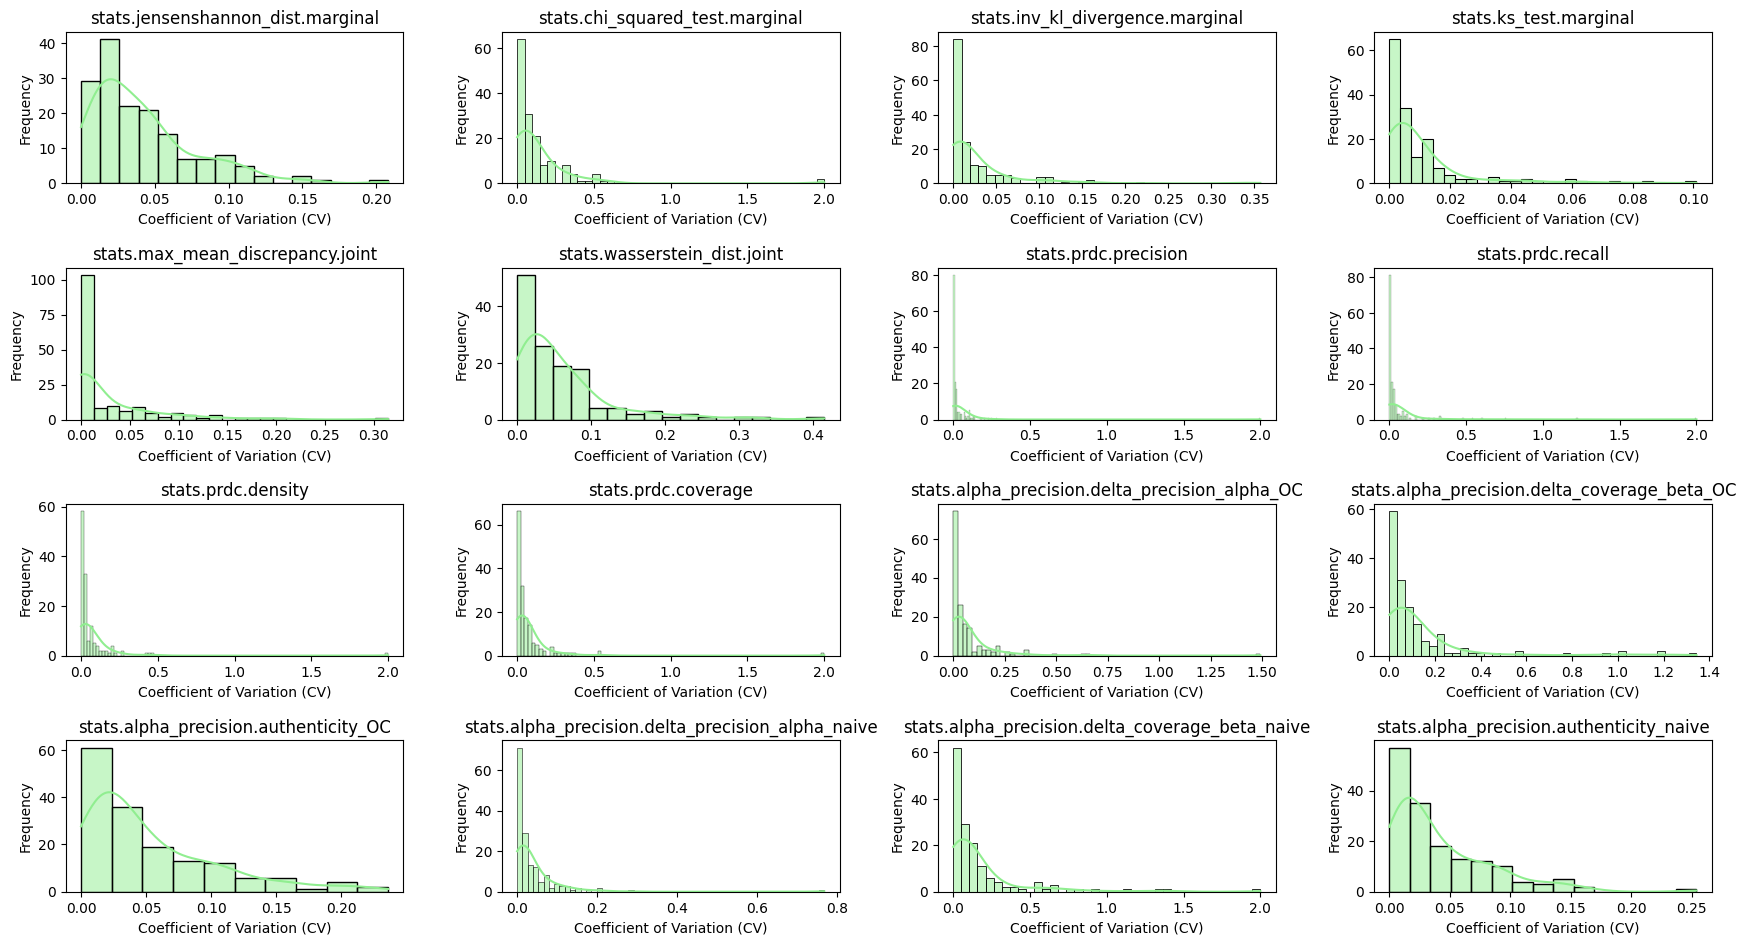

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(18, 10))  
fig.tight_layout(pad=4.0)  

unique_metrics = results_df['metric'].unique()

for i, metric in enumerate(stats):
    ax = axes[i // 4, i % 4] 
    sns.histplot(results_df[results_df['metric'] == metric]['CV'], kde=True, ax=ax, color='lightgreen')
    ax.set_title(metric)  
    ax.set_xlabel('Coefficient of Variation (CV)') 
    ax.set_ylabel('Frequency')

plt.show()

#### Performance metrics cv results

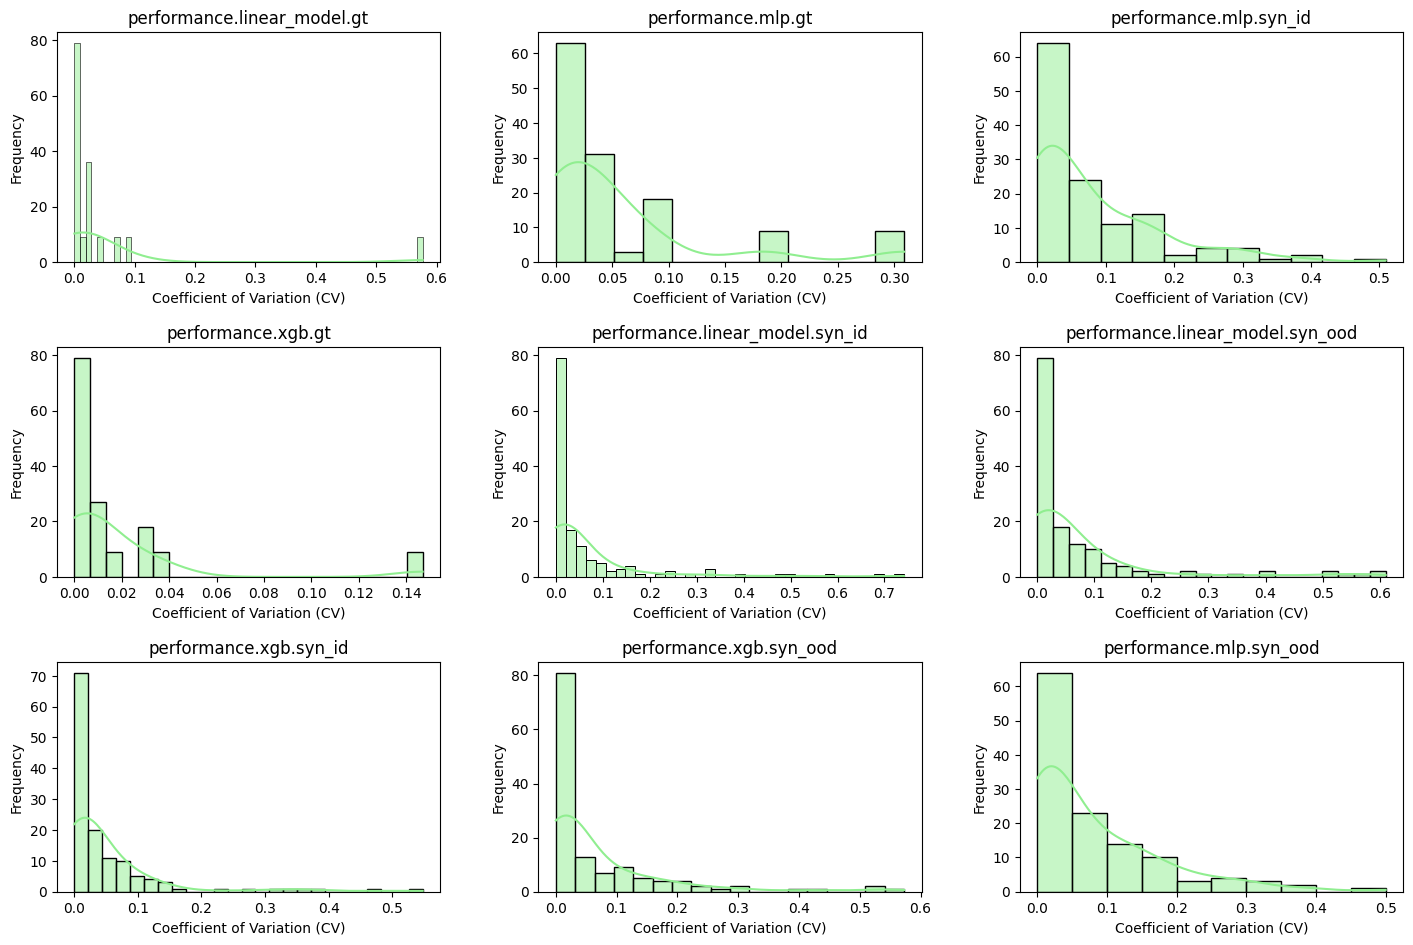

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  
fig.tight_layout(pad=4.0)  

unique_metrics = results_df['metric'].unique()

for i, metric in enumerate(performance):
    ax = axes[i // 3, i % 3] 
    sns.histplot(results_df[results_df['metric'] == metric]['CV'], kde=True, ax=ax, color='lightgreen')
    ax.set_title(metric)  
    ax.set_xlabel('Coefficient of Variation (CV)') 
    ax.set_ylabel('Frequency')

plt.show()

#### Privacy metrics cv results

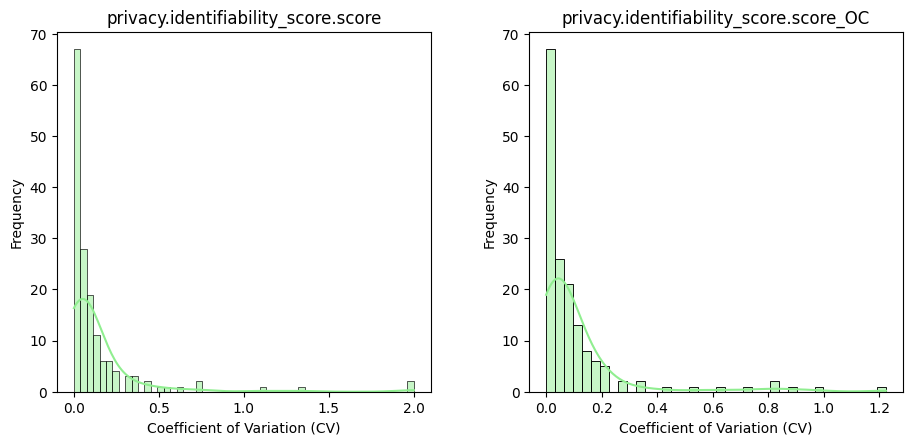

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  
fig.tight_layout(pad=4.0)  

unique_metrics = results_df['metric'].unique()

for i, metric in enumerate(privacy):
    ax = axes[i] 
    sns.histplot(results_df[results_df['metric'] == metric]['CV'], kde=True, ax=ax, color='lightgreen')
    ax.set_title(metric)  
    ax.set_xlabel('Coefficient of Variation (CV)') 
    ax.set_ylabel('Frequency')

plt.show()

#### Sanity metrics cv results

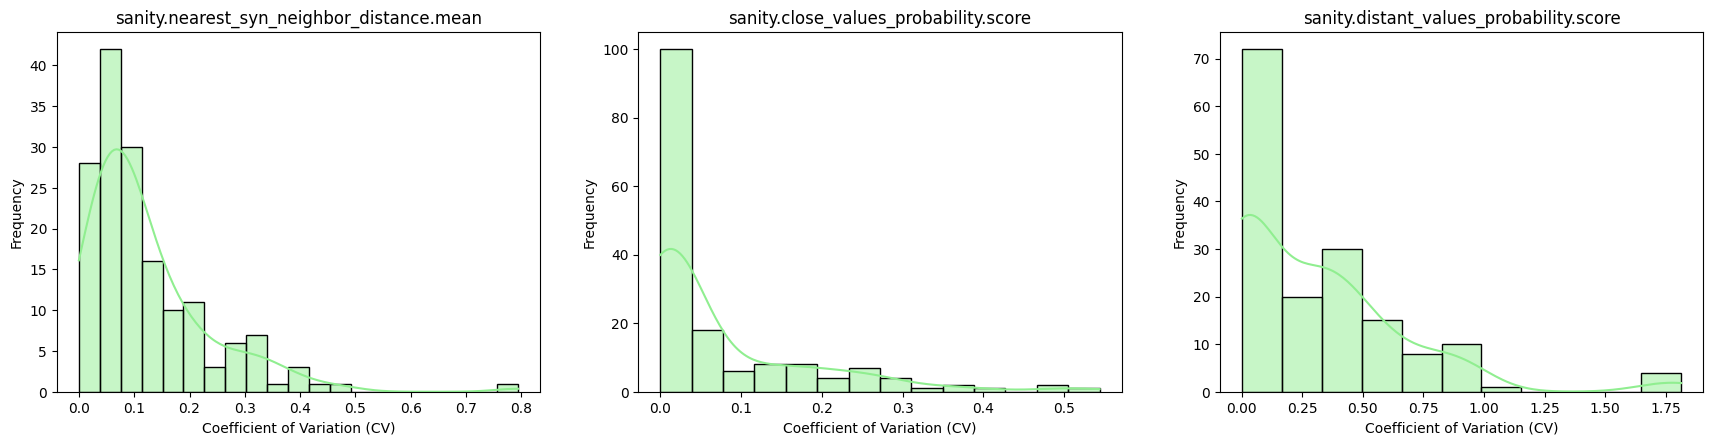

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  
fig.tight_layout(pad=4.0)  

unique_metrics = results_df['metric'].unique()

for i, metric in enumerate(sanity):
    ax = axes[i] 
    sns.histplot(results_df[results_df['metric'] == metric]['CV'], kde=True, ax=ax, color='lightgreen')
    ax.set_title(metric)  
    ax.set_xlabel('Coefficient of Variation (CV)') 
    ax.set_ylabel('Frequency')

plt.show()

#### Detection metrics cv results

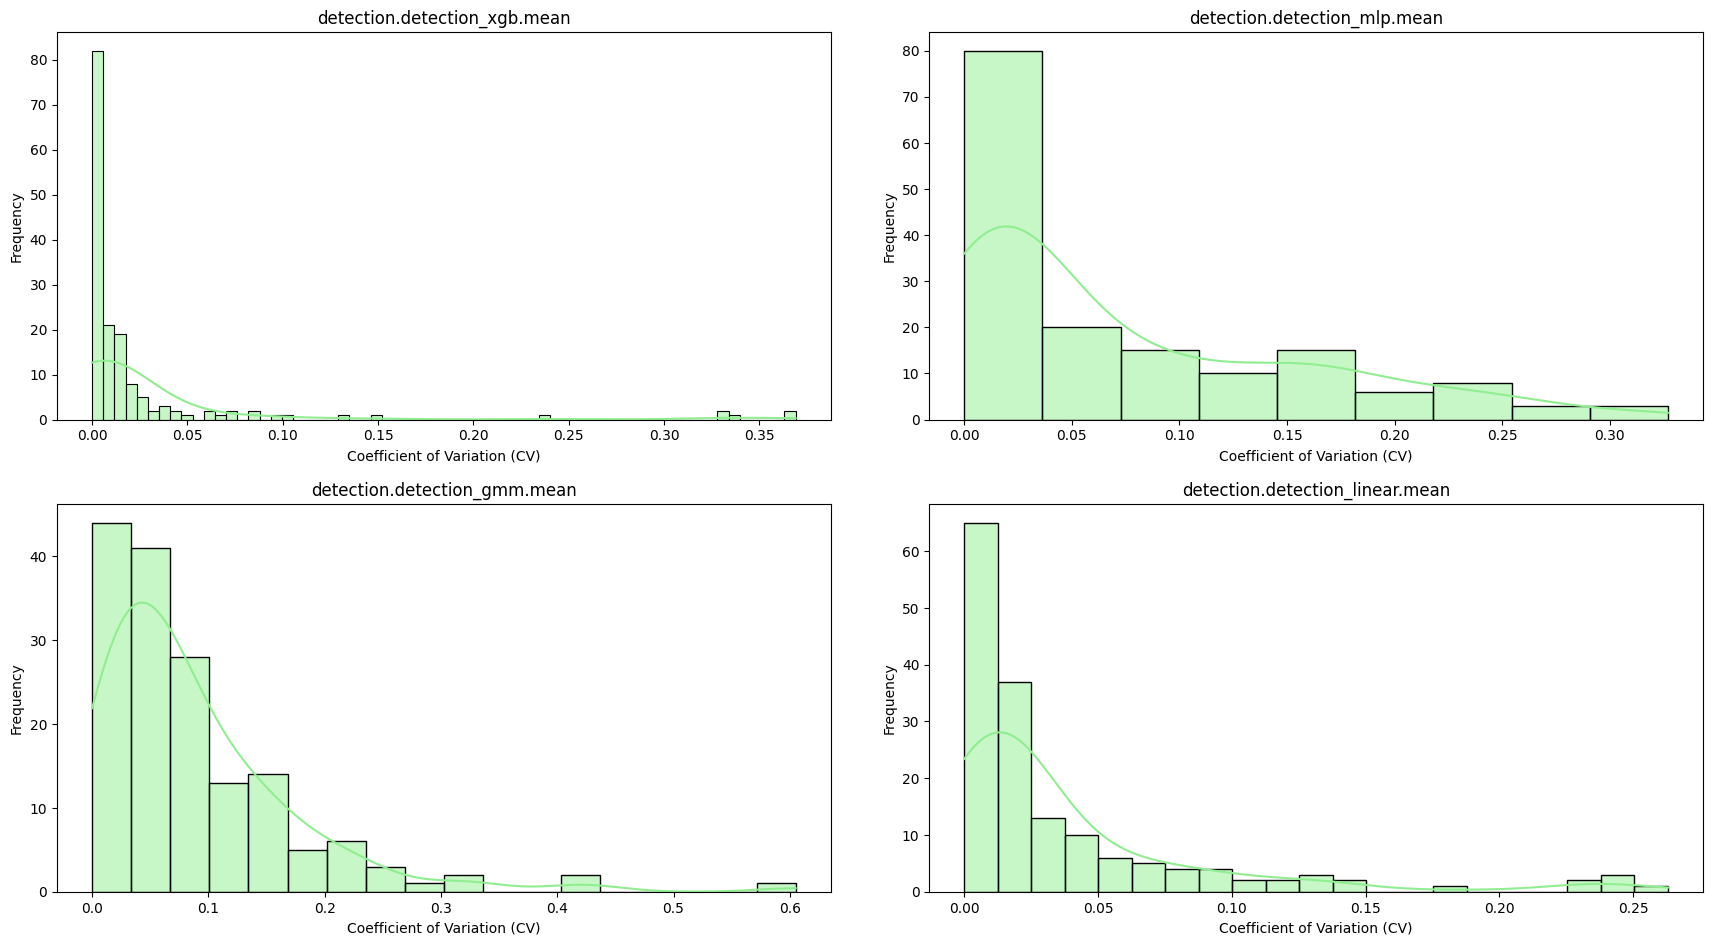

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))  
fig.tight_layout(pad=4.0)  

unique_metrics = results_df['metric'].unique()

for i, metric in enumerate(detection):
    ax = axes[i // 2, i % 2] 
    sns.histplot(results_df[results_df['metric'] == metric]['CV'], kde=True, ax=ax, color='lightgreen')
    ax.set_title(metric)  
    ax.set_xlabel('Coefficient of Variation (CV)') 
    ax.set_ylabel('Frequency')

plt.show()

## Models analysis


### All metrics

Counts for metrics that gave decent generation results (with median value >= 0.7 for 'maximize' direction and value<= 0.1 for 'minimize' direction)

In [13]:
model_results = {}

for df in df_names:
    for model in models:
        data = pd.read_csv(f'{benchmark_results}/{df}/{model}/res_df.csv', index_col='Unnamed: 0')
        clear_data = data[~data.index.isin(metrics_to_drop)]
        valuable_metrics = clear_data[(clear_data['min'] >= 0) & (clear_data['max'] <= 1) & (clear_data['max'] > 0)]

        for idx, values in valuable_metrics.iterrows():
            if df not in model_results:
                model_results[df] = {}

            if model not in model_results[df]:
                model_results[df][model] = []

            if values['direction'] == 'maximize' and values['median'] >= 0.7:
                model_results[df][model].append(idx)

            elif values['direction'] == 'minimize' and values['median'] <= 0.1:
                model_results[df][model].append(idx)

model_metrics_count = {}

for dataset, models in model_results.items():
    for model, metrics in models.items():
        if model not in model_metrics_count:
            model_metrics_count[model] = 0 
            
        model_metrics_count[model] += len(metrics)  

total_metrics_count = sum(model_metrics_count.values())

counts = pd.DataFrame.from_dict(model_metrics_count, orient='index', columns=['count'])
counts['percentage'] = round((counts['count'] / total_metrics_count) * 100, ndigits=2)
counts.sort_values(by='count', ascending=False)

,count,percentage
bayesian_network,316,12.28
adsgan,307,11.93
tvae,307,11.93
ctgan,291,11.31
ddpm,289,11.23
rtvae,280,10.88
pategan,278,10.80
ganblr,260,10.10
ganblr++,246,9.56


### Grouped metrics

Detection metrics are out of selection and we can drop them (there are any significant results only when median > 0.5, which means that it's slightly better than random result). So for other values that have enough results we will keep filter for median(maximize) >= 0.7 and median(minimize) <= 0.1.

As we can see ganblr, ganblr++, rtvae models show less successful results relatively to stats metrics group. Ganblr, ganblr++, pategan models are a little worse at handling performance metrics. For privacy metrics group bayesian_network, ddpm and tvae models show awful results. All models, except ganblr++ show almost the same result for sanity metrics group.

In the case of ganblr, ganblr++ models, the problem may lie in the fact that the plugins for them were written independently with the synthcity plugin interface and basic parameters used, so in general for stock models these results can be considered successful.

In [14]:
model_metrics_by_group = {}

for dataset, models in model_results.items():
    for model, metrics in models.items():
        if model not in model_metrics_by_group:
            model_metrics_by_group[model] = {'stats': 0, 'performance': 0, 'privacy': 0, 'sanity': 0, 'detection': 0}
        
        for metric in metrics:
            group = categorize_metric(metric)
            model_metrics_by_group[model][group] += 1

counts_by_group = pd.DataFrame.from_dict(model_metrics_by_group, orient='index')
counts_by_group.drop(columns=['detection'], inplace=True)
total_metrics_by_group = counts_by_group.sum(axis=0)


for group in ['stats', 'performance', 'privacy', 'sanity']:
    counts_by_group[f'{group}_%'] = (counts_by_group[group] / total_metrics_by_group[group]) * 100

counts_by_group = counts_by_group.round(2)

columns_order = []
for group in ['stats', 'performance', 'privacy', 'sanity']:
    columns_order.extend([group, f'{group}_%'])

counts_by_group = counts_by_group[columns_order]
counts_by_group.loc["Total"] = counts_by_group.sum()

counts_by_group

,stats,stats_%,performance,performance_%,privacy,privacy_%,sanity,sanity_%
adsgan,162.0,12.11,96.0,11.68,8.0,10.26,41.0,12.20
bayesian_network,178.0,13.30,100.0,12.17,1.0,1.28,37.0,11.01
ctgan,149.0,11.14,93.0,11.31,9.0,11.54,40.0,11.90
ddpm,151.0,11.29,99.0,12.04,4.0,5.13,35.0,10.42
ganblr,131.0,9.79,81.0,9.85,13.0,16.67,35.0,10.42
ganblr++,116.0,8.67,82.0,9.98,15.0,19.23,33.0,9.82
pategan,153.0,11.43,79.0,9.61,10.0,12.82,36.0,10.71
rtvae,132.0,9.87,94.0,11.44,16.0,20.51,38.0,11.31
tvae,166.0,12.41,98.0,11.92,2.0,2.56,41.0,12.20
Total,1338.0,100.01,822.0,100.00,78.0,100.00,336.0,99.99


#### Stats metrics

For stats.jensenshannon_dist.marginal, stats.ks_test.marginal, stats.max_mean_discrepancy.joint	metrics all models show good results. Ganlr, ganblr++ and rtvae models have smaller results for most stats metrics group. Bayesian network, adsgan, tvae models show pretty good results for most metrics. There are a lot of sensitive metrics as they show small results in more than half cases. The most sensitive are stats.prdc.coverage, stats.alpha_precision.authenticity_OC, stats.wasserstein_dist.joint, stats.prdc.density,
stats.chi_squared_test.marginal.

In [15]:
model_metrics = {}

for df in df_names:
    for model in models:
        data = pd.read_csv(f'{benchmark_results}/{df}/{model}/res_df.csv', index_col='Unnamed: 0')
        clear_data = data[~data.index.isin(metrics_to_drop)]
        valuable_metrics = clear_data[(clear_data['min'] >= 0) & (clear_data['max'] <= 1) & (clear_data['max'] > 0)]

        for idx, values in valuable_metrics.iterrows():
            if df not in model_metrics:
                model_metrics[df] = {}

            if model not in model_metrics[df]:
                model_metrics[df][model] = {}

            metric_name = values.name  # Assuming index name is the metric name

            if values['direction'] == 'maximize' and values['median'] >= 0.7:
                if metric_name not in model_metrics[df][model]:
                    model_metrics[df][model][metric_name] = 0
                model_metrics[df][model][metric_name] += 1

            elif values['direction'] == 'minimize' and values['median'] <= 0.1:
                if metric_name not in model_metrics[df][model]:
                    model_metrics[df][model][metric_name] = 0
                model_metrics[df][model][metric_name] += 1

In [16]:
metric_counts = {}

for dataset, models in model_metrics.items():
    for model, metrics in models.items():
        for metric_name, count in metrics.items():
            if model not in metric_counts:
                metric_counts[model] = {}
            
            if metric_name not in metric_counts[model]:
                metric_counts[model][metric_name] = 0
            
            metric_counts[model][metric_name] += count

metric_counts_df = pd.DataFrame.from_dict(metric_counts, orient='columns').fillna(0)

stats_df = metric_counts_df.filter(like='stats', axis=0)
performance_df = metric_counts_df.filter(like='performance', axis=0)
privacy_df = metric_counts_df.filter(like='privacy', axis=0)
sanity_df = metric_counts_df.filter(like='sanity', axis=0)

stats_df

,adsgan,bayesian_network,ctgan,ddpm,ganblr,ganblr++,pategan,rtvae,tvae
stats.jensenshannon_dist.marginal,18,18.0,18,18,17,17.0,18,18,18.0
stats.ks_test.marginal,16,18.0,14,12,12,8.0,14,11,17.0
stats.max_mean_discrepancy.joint,17,17.0,17,16,16,16.0,17,16,17.0
stats.prdc.precision,14,16.0,12,13,8,8.0,11,15,14.0
stats.prdc.recall,17,18.0,16,16,15,13.0,18,6,18.0
stats.prdc.coverage,9,15.0,7,13,5,3.0,7,4,14.0
stats.alpha_precision.authenticity_OC,6,4.0,5,5,8,13.0,8,8,5.0
stats.alpha_precision.delta_precision_alpha_naive,14,18.0,15,11,5,2.0,13,12,14.0
stats.inv_kl_divergence.marginal,13,15.0,13,13,12,11.0,13,6,13.0
stats.wasserstein_dist.joint,7,9.0,8,5,2,0.0,6,8,8.0


#### Performance metrics

Earlier we have seen that ganblr, ganblr++ and pategan models are pretty bad at handling performance metrics, but if we look at the table 'performance_df' we see that all models have awful results for performance.mlp.gt, performance.mlp.syn_id, performance.mlp.syn_ood metrics. Pategan, ganblr and ganblr++ have worse results than other models for 2 metrics: performance.linear_model.syn_id and performance.linear_model.syn_ood. 

In [17]:
performance_df

,adsgan,bayesian_network,ctgan,ddpm,ganblr,ganblr++,pategan,rtvae,tvae
performance.linear_model.gt,15,15.0,15,15,14,14.0,15,15,15.0
performance.xgb.gt,16,16.0,16,16,15,15.0,16,16,16.0
performance.xgb.syn_id,12,15.0,12,13,11,12.0,10,12,13.0
performance.xgb.syn_ood,13,12.0,12,13,11,12.0,9,11,13.0
performance.linear_model.syn_id,13,15.0,12,13,9,9.0,8,13,13.0
performance.linear_model.syn_ood,12,12.0,12,14,9,8.0,8,13,13.0
performance.mlp.gt,6,6.0,5,6,5,5.0,6,6,6.0
performance.mlp.syn_id,4,4.0,4,4,3,3.0,4,4,4.0
performance.mlp.syn_ood,5,5.0,5,5,4,4.0,3,4,5.0


#### Privacy metrics

bayesian_network, ddpm, tvae models showed worst results for privacy metrics group. But as we can see in 'privacy_df' table all models have poor results for both privacy.identifiability_score.score and privacy.identifiability_score.score_OC metrics showing decent results only for less than half of the tables, so we can choose them as the metrics, that are pretty sensitive

In [18]:
privacy_df

,adsgan,bayesian_network,ctgan,ddpm,ganblr,ganblr++,pategan,rtvae,tvae
privacy.identifiability_score.score,5,1.0,6,3,7,8.0,6,11,2.0
privacy.identifiability_score.score_OC,3,0.0,3,1,6,7.0,4,5,0.0


#### Sanity metrics

As we have seen previously all models show almost the same results for sanity metrics group. But if we look at the metrics individually we will see that bayesian_network, ddpm, ganblr, ganblr++, pategan, rtvae models show good results for sanity.nearest_syn_neighbor_distance.mean for no more than half of the tables. Also ddpm model showed bad results in half of the cases. So we can use metrics sanity.nearest_syn_neighbor_distance.mean and sanity.close_values_probability.score as they can identify synthetic data better than other metrics. 

In [19]:
sanity_df

,adsgan,bayesian_network,ctgan,ddpm,ganblr,ganblr++,pategan,rtvae,tvae
sanity.nearest_syn_neighbor_distance.mean,11,9.0,11,9,9,8.0,7,9,11.0
sanity.close_values_probability.score,13,11.0,13,9,11,10.0,11,11,12.0
sanity.distant_values_probability.score,17,17.0,16,17,15,15.0,18,18,18.0


### Metrics chosen based on model analysis

* stats

stats.prdc.coverage\
stats.alpha_precision.authenticity_OC\
stats.wasserstein_dist.joint\
stats.prdc.density\
stats.chi_squared_test.marginal

* performance

performance.linear_model.syn_id\
performance.linear_model.syn_ood\
performance.mlp.gt\
performance.mlp.syn_id\
performance.mlp.syn_ood


* privacy

privacy.identifiability_score.score\
privacy.identifiability_score.score_OC

* sanity

sanity.nearest_syn_neighbor_distance.mean\
sanity.close_values_probability.score

## Data properties analysis

### Selection by groups

In [21]:
data_p = pd.read_csv('df_properties.csv')
df_metrics_counts = {}

for dataset, models in model_metrics.items():
    for model, metrics in models.items():
        for metric_name, count in metrics.items():
            if dataset not in df_metrics_counts:
                df_metrics_counts[dataset] = {}
            
            if metric_name not in df_metrics_counts[dataset]:
                df_metrics_counts[dataset][metric_name] = 0
            
            df_metrics_counts[dataset][metric_name] += count

metrics_counts_by_df = pd.DataFrame.from_dict(df_metrics_counts, orient='columns').fillna(0)

stats_metrics_df = metrics_counts_by_df.filter(like='stats', axis=0)
stats_metrics_df.loc['Total'] = round((stats_metrics_df.sum(axis=0) / 126) * 100, 1)

performance_metrics_df = metrics_counts_by_df.filter(like='performance', axis=0)
performance_metrics_df.loc['Total'] = round((performance_metrics_df.sum(axis=0) / 81) * 100, 1)

privacy_metrics_df = metrics_counts_by_df.filter(like='privacy', axis=0)
privacy_metrics_df.loc['Total'] = round((privacy_metrics_df.sum(axis=0) / 18) * 100, 1)

sanity_metrics_df = metrics_counts_by_df.filter(like='sanity', axis=0)
sanity_metrics_df.loc['Total'] = round((sanity_metrics_df.sum(axis=0) / 27) * 100, 1)

/var/folders/jn/_k9_740x0d9_y3_7t5vd9q6w0000gn/T/ipykernel_53752/3321481028.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_metrics_df.loc['Total'] = round((stats_metrics_df.sum(axis=0) / 126) * 100, 1)
/var/folders/jn/_k9_740x0d9_y3_7t5vd9q6w0000gn/T/ipykernel_53752/3321481028.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  performance_metrics_df.loc['Total'] = round((performance_metrics_df.sum(axis=0) / 81) * 100, 1)
/var/folders/jn/_k9_740x0d9_y3_7t5vd9q6w0000gn/T/ipykernel_53752/3321481028.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

In [22]:
data_p['stats %'] = data_p['dataset'].map(stats_metrics_df.loc['Total'])
data_p['performance %'] = data_p['dataset'].map(performance_metrics_df.loc['Total'])
data_p['privacy %'] = data_p['dataset'].map(privacy_metrics_df.loc['Total'])
data_p['sanity %'] = data_p['dataset'].map(sanity_metrics_df.loc['Total'])

data_p.sort_values(by=['total values'], ascending=False)

,dataset,rows,columns,total values,task,multiclass target,stats %,performance %,privacy %,sanity %
7,adult,48842,15,732630,Classification,no,61.9,51.9,22.2,100.0
12,heloc_dataset_v1,10459,24,251016,Classification,no,46.8,66.7,0.0,66.7
4,online_shoppers_intention,12330,18,221940,Classification,no,66.7,61.7,16.7,100.0
2,magic04,19020,11,209220,Classification,no,70.6,90.1,11.1,96.3
0,pendigits,10992,17,186864,Classification,yes,57.9,66.7,66.7,33.3
3,nursery,12958,9,116622,Classification,yes,70.6,100.0,0.0,29.6
15,562_cpu_small,8192,13,106496,Regression,-,72.2,21.0,5.6,100.0
6,us_location,20400,5,102000,Classification,yes,62.7,51.9,66.7,74.1
1,page_blocks,5473,11,60203,Classification,yes,54.0,100.0,50.0,100.0
9,phoneme,5404,6,32424,Classification,no,70.6,87.7,5.6,33.3


## Statistical comparison of all metrics across all models using the Friedman test

In [25]:
results_by_model = {}

for df in df_names:
    for model in models:
        data = pd.read_csv(f'{benchmark_results}/{df}/{model}/res_df.csv', index_col='Unnamed: 0')
        clear_data = data[~data.index.isin(metrics_to_drop)]  
        valuable_metrics = clear_data[(clear_data['min'] >= 0) & (clear_data['max'] <= 1) & (clear_data['max'] > 0)]  

        for idx, values in valuable_metrics.iterrows():
            metric_name = values.name  
            direction = values['direction']
            
            mean_value = values['mean']
            if direction == 'minimize':
                mean_value *= -1
            
            if df not in results_by_model:
                results_by_model[df] = {}

            if model not in results_by_model[df]:
                results_by_model[df][model] = {}

            if metric_name not in results_by_model[df][model]:
                results_by_model[df][model][metric_name] = []

            results_by_model[df][model][metric_name].append(mean_value)

model_averages = {}
    
for dataset, models in results_by_model.items():
    for model, metrics in models.items():
        if model not in model_averages:
            model_averages[model] = {}
    
        for metric_name, values in metrics.items():
            if metric_name not in model_averages[model]:
                model_averages[model][metric_name] = []
                
            model_averages[model][metric_name].append(np.mean(values))

for model, metrics in model_averages.items():
    for metric_name, values in metrics.items():
        model_averages[model][metric_name] = np.mean(values)

In [26]:
from scipy.stats import friedmanchisquare

metrics = list(next(iter(model_averages.values())).keys())

data = []

for metric in metrics:
    row = []
    for model in model_averages:
        row.append(model_averages[model][metric])
    data.append(row)

data = np.array(data)
stat, p_value = friedmanchisquare(*data.T)

print(f'Friedman test statistic: {stat:.3f}')
print(f'p-value: {p_value:.7f}')

Friedman test statistic: 37.010
p-value: 0.0000115


## Conclusion

Thus, we have a distribution of the variation coefficient by 4 groups of metrics: stats, performance, privacy, sanity, for each metric separately, which helps to understand how much our values ​​deviate from the average, and we also have calculated the number of metrics that have good results depending on the direction of maximize and minimize. With this data, we can look at the intersection of metrics with a high variation coefficient (more than 0.3%) and metrics that have shown good results on different models. Thus, we can highlight the most sensitive metrics that are likely to distinguish synthetics from real data. For sanity group distribution of variation coefficient for sanity.distant_values_probability.score metric was spread more than 0.3%, but in case with our datasets it showed pretty decent results (metrics had high values for most datasets), so for sanity metrics group we can keep only sanity.nearest_syn_neighbor_distance.mean and sanity.close_values_probability.score as they are more sensitive. For privacy group we can say both metrics are sensitive enough to distinguish synthetic data as the variation coefficents spread for both of them are high and metrics results are low in many cases. For the performance metrics we have intersection for performance.linear_model.syn_id, performance.linear_model.syn_ood, performance.mlp.gt, performance.mlp.syn_id, performance.mlp.syn_ood. And for the last group intersection was for stats.prdc.coverage, stats.wasserstein_dist.joint, stats.prdc.density, stats.chi_squared_test.marginal metrics. Also, stats.alpha_precision.authenticity_OC metric showed awful results for most models except ganblr++, but variation coefficient distribution highest value is lower than 0.3% so it didn't catched this dependence. So the final list of metrics we can use to distinguish synthetic data looks like this:

* Stats

stats.prdc.coverage\
stats.wasserstein_dist.joint\
stats.prdc.density\
stats.chi_squared_test.marginal\
stats.alpha_precision.authenticity_OC

* Performance

performance.linear_model.syn_id\
performance.linear_model.syn_ood\
performance.mlp.gt\
performance.mlp.syn_id\
performance.mlp.syn_ood

* Privacy

privacy.identifiability_score.score\
privacy.identifiability_score.score_OC

* Sanity

sanity.nearest_syn_neighbor_distance.mean\
sanity.close_values_probability.score